<img src="../data/ner_tags.png">

In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn_crfsuite.metrics import flat_classification_report

Using TensorFlow backend.


In [2]:
data = pd.read_csv("../data/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
n_tags = len(tags)
print("Number of Labels: ", n_tags)
print(tags)

data.head(10)

Number of sentences:  47959
Number of words in the dataset:  35178
Number of Labels:  17
['B-eve', 'B-geo', 'B-org', 'I-geo', 'B-art', 'I-tim', 'I-eve', 'B-nat', 'I-per', 'O', 'I-nat', 'I-gpe', 'B-per', 'I-art', 'I-org', 'B-gpe', 'B-tim']


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
class SentenceGetter(object):
    """
    Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]
    """
    
    def __init__(self, data):
        """
        data: pandas.DataFrame which contains the above dataset
        """
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [4]:
getter = SentenceGetter(data)
sentences = getter.sentences

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))

Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O


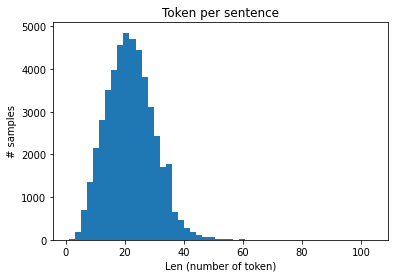

In [5]:
# Plot sentence by length
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [6]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

In [7]:
# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

In [8]:
# Max length of review (in words)
MAX_LEN = 60

# Convert each sentence from list of Token to list of word_index
X_word = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X_word = pad_sequences(maxlen=MAX_LEN, sequences=X_word, padding="post", value=word2idx["PAD"])

In [9]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

98


In [10]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [11]:
def generate_char_array(input_sent, raw=False):
    sent_seq = []
    for i in range(MAX_LEN):
        word_seq = []
        for j in range(MAX_LEN_CHAR):
            try:
                if raw:
                    word_seq.append(char2idx.get(input_sent[i][j]))
                else:
                    word_seq.append(char2idx.get(input_sent[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    return np.array(sent_seq)

In [12]:
MAX_LEN_CHAR = 10

X_char = []
for sentence in sentences:
    char_array = generate_char_array(sentence)
    X_char.append(char_array)
    
X_char = np.array(X_char)

In [13]:
# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

# One-Hot encode
y = np.array([to_categorical(i, num_classes=n_tags+1) for i in y])  # n_tags+1(PAD)

In [14]:
# Train-test split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1)

X_word_tr.shape, X_char_tr.shape, np.array(y_tr).shape

((43163, 60), (43163, 60, 10), (43163, 60, 18))

In [15]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, concatenate
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

EPOCHS = 10
BATCH_SIZE = 256
WORD_EMBEDDING_DIM = 50
CHAR_EMBEDDIBG_DIM = 10

# input and embeddings for characters
char_in = Input(shape=(MAX_LEN, MAX_LEN_CHAR,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars+2,
                                     output_dim=CHAR_EMBEDDIBG_DIM,
                                     input_length=MAX_LEN_CHAR))(char_in)

# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, 
                                return_sequences=False,
                                recurrent_dropout=0.2))(emb_char)

# input and embedding for words
word_in = Input(shape=(MAX_LEN,))
emb_word = Embedding(input_dim=n_words+2, 
                     output_dim=WORD_EMBEDDING_DIM, 
                     input_length=MAX_LEN)(word_in)

# combine word and char embeddings
x = concatenate([emb_word, char_enc])

# Main layers
main_lstm = Bidirectional(LSTM(units=64, 
                               return_sequences=True,
                               recurrent_dropout=0.2))(x)
fc = TimeDistributed(Dense(50, activation="relu"))(main_lstm)
out = CRF((n_tags + 1))(fc)


model = Model([word_in, char_in], out)
model.compile(optimizer="adam", loss=crf_loss, metrics=[crf_accuracy])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 10)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 60, 10, 10)   1000        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 50)       1759000     input_2[0][0]                    
____________________________________________________________________________________________

In [16]:
history = model.fit([X_word_tr, X_char_tr], y_tr, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=2)
stats = pd.DataFrame(history.history)

/home/sun/miniconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38846 samples, validate on 4317 samples
Epoch 1/10
 - 18s - loss: 0.6120 - crf_accuracy: 0.8428 - val_loss: 0.2522 - val_crf_accuracy: 0.9458
Epoch 2/10
 - 16s - loss: 0.1888 - crf_accuracy: 0.9485 - val_loss: 0.1193 - val_crf_accuracy: 0.9621
Epoch 3/10
 - 16s - loss: 0.1010 - crf_accuracy: 0.9675 - val_loss: 0.0790 - val_crf_accuracy: 0.9762
Epoch 4/10
 - 16s - loss: 0.0586 - crf_accuracy: 0.9821 - val_loss: 0.0483 - val_crf_accuracy: 0.9849
Epoch 5/10
 - 16s - loss: 0.0367 - crf_accuracy: 0.9879 - val_loss: 0.0391 - val_crf_accuracy: 0.9866
Epoch 6/10
 - 17s - loss: 0.0280 - crf_accuracy: 0.9895 - val_loss: 0.0354 - val_crf_accuracy: 0.9874
Epoch 7/10
 - 16s - loss: 0.0230 - crf_accuracy: 0.9905 - val_loss: 0.0325 - val_crf_accuracy: 0.9878
Epoch 8/10
 - 16s - loss: 0.0191 - crf_accuracy: 0.9914 - val_loss: 0.0311 - val_crf_accuracy: 0.9880
Epoch 9/10
 - 17s - loss: 0.0160 - crf_accuracy: 0.9919 - val_loss: 0.0293 - val_crf_accuracy: 0.9881
Epoch 10/10
 - 17s - loss: 0.0131

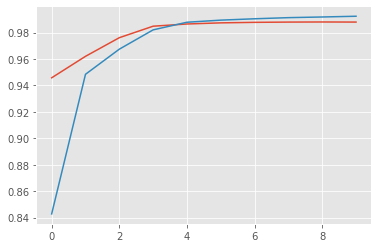

In [17]:
plt.style.use("ggplot")
plt.plot(stats["val_crf_accuracy"])
plt.plot(stats["crf_accuracy"])
plt.show()

In [18]:
# Eval on test data
pred_cat = model.predict([X_word_te, X_char_te])
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [19]:
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

/home/sun/miniconda2/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        39
       B-eve       0.00      0.00      0.00        22
       B-geo       0.86      0.88      0.87      3780
       B-gpe       0.96      0.94      0.95      1551
       B-nat       0.00      0.00      0.00        27
       B-org       0.78      0.69      0.73      2005
       B-per       0.83      0.83      0.83      1682
       B-tim       0.91      0.88      0.89      2016
       I-art       0.00      0.00      0.00        26
       I-eve       0.00      0.00      0.00         9
       I-geo       0.80      0.71      0.75       684
       I-gpe       1.00      0.63      0.77        19
       I-nat       0.00      0.00      0.00         5
       I-org       0.85      0.70      0.77      1682
       I-per       0.89      0.81      0.85      1762
       I-tim       0.82      0.73      0.77       616
           O       0.98      0.99      0.99     88713
         PAD       1.00    

In [20]:
def check_sample(ner_model, sample_x, sample_y):
    raw_pred = ner_model.predict(sample_x)
    tag_pred = np.argmax(raw_pred, axis=-1)[0]
    ground_truth = np.argmax(sample_y, axis=-1)
    
    print("{:15}{:7}{}".format("WORD", "TRUE", "PRED"))
    for w, t, p in zip(sample_x[0][0], ground_truth, tag_pred):
        if w != 0:
            print("{:15}{:7}{}".format(idx2word[w], idx2tag[t], idx2tag[p]))

index = 2
check_sample(model, [[X_word[index]], [X_char[index]]], y[index])

WORD           TRUE   PRED
Helicopter     O      O
gunships       O      O
Saturday       B-tim  B-tim
pounded        O      O
militant       O      O
hideouts       O      O
in             O      O
the            O      O
Orakzai        B-geo  B-geo
tribal         O      O
region         O      O
,              O      O
where          O      O
many           O      O
Taliban        B-org  B-org
militants      O      O
are            O      O
believed       O      O
to             O      O
have           O      O
fled           O      O
to             O      O
avoid          O      O
an             O      O
earlier        O      O
military       O      O
offensive      O      O
in             O      O
nearby         O      O
South          B-geo  B-geo
Waziristan     I-geo  I-geo
.              O      O


In [21]:
def predict_sentence(ner_model):
    input_sent = input("Input sentence: ")
    sequence = [word2idx.get(w, 1) for w in word_tokenize(input_sent)]
    processed_sent = pad_sequences(sequences=[sequence],
                                   padding="post", 
                                   value=0, 
                                   maxlen=MAX_LEN)
    char_array = generate_char_array(sequence, raw=True)

    raw_pred = ner_model.predict([[processed_sent.squeeze()], [char_array]])
    tag_pred = np.argmax(raw_pred, axis=-1)[0]
    
    print("\n{:15}{}".format("WORD", "PRED"))
    for w, p in zip(sequence, tag_pred):
        if w != 0:
            print("{:15}{}".format(idx2word[w], idx2tag[p]))

predict_sentence(model)

Input sentence: Jim visited Beijing in 2016.

WORD           PRED
Jim            B-per
visited        O
Beijing        B-geo
in             O
2016           B-tim
.              O
